In [1]:
## ---- Global Cell Set Doublet Testing with DoubletDecon ---- 0687.00.00
## This notebook will be abandoned in favor of 0687.02.00 which uses
## the downsampled/remixed cell set 
## Load aggregated data set (previously unprocessed 10x data)
## Perform DoubletDecon analysis
## Save doublet scores, predicted doublets, and cell barcodes

In [2]:
# if(!require(devtools)){
#   install.packages("devtools") # If not already installed
# }
# devtools::install_github('EDePasquale/DoubletDecon')

In [1]:
# lpath <- "/gpfs/group/torkamani/devans/Rmodules.DoubletDecon/3.5/"
# if (!(lpath %in% .libPaths())) .libPaths(c(lpath, .libPaths()))   
privpath <- .libPaths()[1]
pubpath <- .libPaths()[2]
ddpath <- '/gpfs/group/torkamani/devans/Rmodules/DoubletDecon'
Seuratpath <- '/gpfs/group/torkamani/devans/Rmodules/Seurat'

In [2]:
# .libPaths(ddpath) 
library(DoubletDecon)
# .libPaths(pubpath) 
library(DeconRNASeq)
library(gplots)
library(dplyr)
library(reticulate)
library(MCL)
library(clusterProfiler)
library(mygene)
library(tidyr)
library(R.utils)
library(foreach)
library(doParallel)
library(stringr)
library(Seurat)
library(irlba)
library(patchwork)

In [3]:
## Create a Working Input and Output Data Directory, If It Does Not Exist
parentdir <- '/gpfs/group/torkamani/devans/'
datdir <- paste(parentdir, 'CDC2', sep = '')
if (!file.exists(datdir)) {
    dir.create(datdir)
}
setwd(datdir)

In [4]:
## Read the parameters file
ps <- read.table(file = 'parms.txt', stringsAsFactors = FALSE, header = TRUE)

In [5]:
# ## Set up paths to the 6 sample directories
# pf1d <- paste(ps$indir, ps$conpath, 'p3/dis/outs/filtered_feature_bc_matrix', sep = '')
# pf1h <- paste(ps$indir, ps$conpath, 'p3/hea/outs/filtered_feature_bc_matrix', sep = '')
# pf2d <- paste(ps$indir, ps$conpath, 'p4/dis/outs/filtered_feature_bc_matrix', sep = '')
# pf2h <- paste(ps$indir, ps$conpath, 'p4/hea/outs/filtered_feature_bc_matrix', sep = '')
# pf3d <- paste(ps$indir, ps$conpath, 'p5/dis/outs/filtered_feature_bc_matrix', sep = '')
# pf3h <- paste(ps$indir, ps$conpath, 'p5/hea/outs/filtered_feature_bc_matrix', sep = '')

In [ ]:
# ## Read the six samples
# p1d_cds <- Read10X(data.dir = pf1d)
# p1h_cds <- Read10X(data.dir = pf1h)
# p2d_cds <- Read10X(data.dir = pf2d)
# p2h_cds <- Read10X(data.dir = pf2h)
# p3d_cds <- Read10X(data.dir = pf3d)
# p3h_cds <- Read10X(data.dir = pf3h)

In [ ]:
# ## Create the Seurat Objects
# p1d_cds <- CreateSeuratObject(counts = p1d_cds, project = "Cor.Pat1.Dis", min.cells = 0, min.features = 0)
# p1h_cds <- CreateSeuratObject(counts = p1h_cds, project = "Cor.Pat1.Hea", min.cells = 0, min.features = 0)
# p2d_cds <- CreateSeuratObject(counts = p2d_cds, project = "Cor.Pat2.Dis", min.cells = 0, min.features = 0)
# p2h_cds <- CreateSeuratObject(counts = p2h_cds, project = "Cor.Pat2.Hea", min.cells = 0, min.features = 0)
# p3d_cds <- CreateSeuratObject(counts = p3d_cds, project = "Cor.Pat3.Dis", min.cells = 0, min.features = 0)
# p3h_cds <- CreateSeuratObject(counts = p3h_cds, project = "Cor.Pat3.Hea", min.cells = 0, min.features = 0)

In [22]:
## Data from Tutorial
pbmc.data <- Read10X(data.dir = '/gpfs/group/torkamani/devans/PBMC/filtered_gene_bc_matrices/hg19')
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)

In [23]:
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

In [24]:
# pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)
pbmc <- NormalizeData(pbmc)

In [25]:
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

In [26]:
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



In [27]:
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1, HLA-DPA

In [ ]:
# saveRDS(pbmc, file = "../output/pbmc_tutorial.rds")

In [5]:
# Point to the aggregated single cell data
input_dir <- '/gpfs/group/torkamani/devans/CDC2/inputdat/outs/filtered_feature_bc_matrix'

In [6]:
## Read the aggregated samples
agg_cds1 <- Read10X(data.dir = input_dir)

In [14]:
agg_cds <- agg_cds1

In [15]:
agg_cds <- CreateSeuratObject(counts = agg_cds, project = "agg_cds_6samples", min.cells = 3, min.features = 200)

In [16]:
# agg_cds[["percent.mt"]] <- PercentageFeatureSet(agg_cds, pattern = "^MT-")
# agg_cds <- subset(agg_cds, subset = nFeature_RNA > 200 & nFeature_RNA < 4000 & percent.mt < 5)

In [17]:
agg_cds <- NormalizeData(agg_cds)

In [18]:
agg_cds <- FindVariableFeatures(object = agg_cds, selection.method = "vst")

In [19]:
all.genes <- rownames(agg_cds)
agg_cds <- ScaleData(agg_cds, features = all.genes)

Centering and scaling data matrix



In [20]:
agg_cds  <- RunPCA(agg_cds , features = VariableFeatures(object = agg_cds ))

PC_ 1 
Positive:  IGFBP7, MGP, CALD1, ADIRF, BGN, SPARCL1, NNMT, DSTN, MYL9, CAV1 
	   C1R, SOD3, CAVIN1, TAGLN, CAVIN3, TPM1, CLU, SPARC, OGN, CD151 
	   MFGE8, AEBP1, CTGF, CRYAB, LHFPL6, EFEMP1, SERPING1, COL6A2, IGFBP5, TPM2 
Negative:  CYBA, TYROBP, FCER1G, AIF1, ITGB2, LYZ, PLEK, CTSS, GPR183, CD14 
	   C5AR1, COTL1, CD83, SPI1, CYBB, MS4A6A, MNDA, MS4A7, IGSF6, LST1 
	   RNASET2, HLA-DPB1, CD68, FCGR3A, CD74, SAT1, SERPINA1, HLA-DRA, HLA-DQB1, HLA-DPA1 
PC_ 2 
Positive:  CD69, CCL5, GZMA, IL7R, GZMK, LTB, TRBC1, NKG7, ISG20, CTSW 
	   CD7, GZMH, KLRB1, TENT5C, CCR7, CD8A, CD27, HOPX, PRF1, CD8B 
	   TNF, IGKC, KLRD1, PIM2, GNLY, GZMB, IFNG, TIGIT, CD40LG, XCL1 
Negative:  CST3, PSAP, CD14, FTL, AIF1, CD68, GRN, CTSZ, CEBPD, CTSB 
	   FCER1G, C5AR1, FTH1, LYZ, MS4A7, TYROBP, CPVL, MAFB, MS4A6A, BLVRB 
	   IGSF6, FCGR2A, PLAUR, SPI1, CTSL, TMEM176B, MARCKS, CYBB, MNDA, SERPINA1 
PC_ 3 
Positive:  ECSCR, RAMP2, CLEC14A, PECAM1, PLVAP, IFI27, VWF, PALMD, RAMP3, SOX18 
	   ADGRL4, EG

In [21]:
agg_cds <- FindNeighbors(agg_cds, dims = 1:10)
agg_cds <- FindClusters(agg_cds, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 51275
Number of edges: 1544078

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9315
Number of communities: 21
Elapsed time: 18 seconds


In [22]:
agg_cds <- RunUMAP(agg_cds, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
11:24:52 UMAP embedding parameters a = 0.9922 b = 1.112

11:24:52 Read 51275 rows and found 10 numeric columns

11:24:52 Using Annoy for neighbor search, n_neighbors = 30

11:24:52 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

11:25:10 Writing NN index file to temp file /scratch/RtmplxN1Oy/file1f0b73beaf00c

11:25:10 Searching Annoy index using 1 thread, search_k = 3000

11:25:38 Annoy recall = 100%

11:25:40 Commencing smooth kNN distance calibration using 1 thread

11:25:46 Initializ

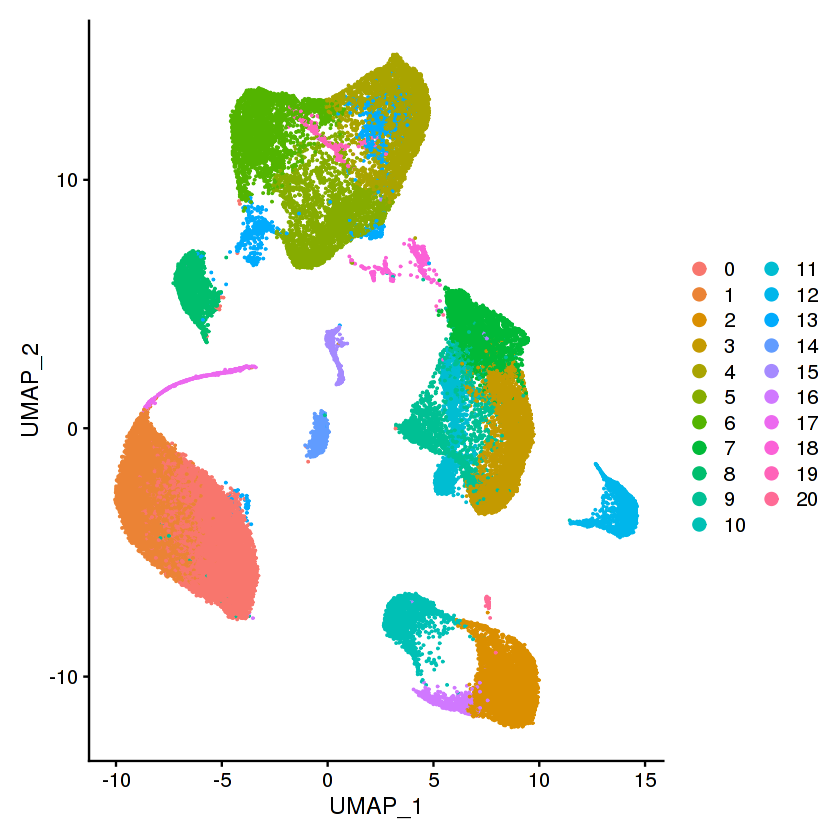

In [23]:
DimPlot(agg_cds, reduction = "umap")

In [24]:
saveRDS(agg_cds, file = '/gpfs/group/torkamani/devans/CDC2/outputdat/ddcon.rev1.rds')

In [25]:
newFiles1 <- Improved_Seurat_Pre_Process(agg_cds, num_genes=50, write_files=FALSE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Warning message:
“The following arguments are not used: thresh.use”


In [26]:
newFiles <- newFiles1

In [ ]:
results1 <- Main_Doublet_Decon(rawDataFile=newFiles$newExpressionFile, 
                           groupsFile=newFiles$newGroupsFile, 
                           filename='DDcon.Run1', 
                           location='/gpfs/group/torkamani/devans/CDC2/outputdat/',
                           fullDataFile=NULL, 
                           removeCC=FALSE, 
                           species="hsa", 
                           rhop=1.1, 
                           write=TRUE, 
                           PMF=TRUE, 
                           useFull=FALSE, 
                           heatmap=TRUE,
                           centroids=TRUE,
                           num_doubs=100, 
                           only50=FALSE,
                           min_uniq=4,
                           nCores=1)

Loading packages...


Bioconductor version 3.8 (BiocManager 1.30.10), ?BiocManager::install for help

Bioconductor version '3.8' is out-of-date; the current release version '3.11'
  is available with R version '4.0'; see https://bioconductor.org/install

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following object is masked from ‘package:IRanges’:

    desc


The following object is masked from ‘package:S4Vectors’:

    rename


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize




Reading data...
Processing raw data...
Creating original data heatmap...
Combining similar clusters...


In [36]:
object.size(newFiles)

9975727528 bytes